In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image as krimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [2]:
print(tf.__version__)

2.1.0


In [3]:
print(np.__version__)

1.18.1


In [4]:
model = applications.VGG19(weights='imagenet')

574717952/574710816 [==============================] - 381s 1us/step


In [38]:
target = 'elephant2'

img_path = './origin_image/{0}.jpg'.format(target)

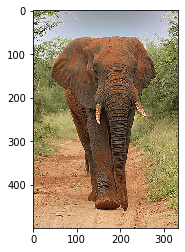

In [38]:
img = mpimg.imread(img_path)
plt.imshow(img)

In [44]:
img = krimage.load_img(img_path, target_size=(224,224))
x = krimage.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

In [40]:
predictions = model.predict(x)
print('predicted: ' , decode_predictions(predictions, top=8)[0])

predicted:  [('n02504458', 'African_elephant', 0.74321383), ('n01871265', 'tusker', 0.24292228), ('n02504013', 'Indian_elephant', 0.013861446), ('n01704323', 'triceratops', 8.636341e-07), ('n02410509', 'bison', 4.4091692e-07), ('n01695060', 'Komodo_dragon', 1.8840194e-07), ('n02397096', 'warthog', 1.8279917e-07), ('n02437312', 'Arabian_camel', 1.7632799e-07)]


In [41]:
with tf.GradientTape() as t:
    out = x
    for layer in model.layers[:17] :
        out = layer(out)
    last_conv_layer_output = out
    for layer in model.layers[17:] :
        out = layer(out)
    predictions = out
    predictions = predictions[:,np.argmax(predictions)]
grads = t.gradient(predictions, last_conv_layer_output)
print(grads.shape)
pooled_grads = np.mean(grads, axis=(0,1,2))
print(pooled_grads.shape)
#pooled_grads_value = pooled_grads.numpy()
last_conv_layer_output_value = last_conv_layer_output[0].numpy()

(1, 14, 14, 512)
(512,)


(14, 14)


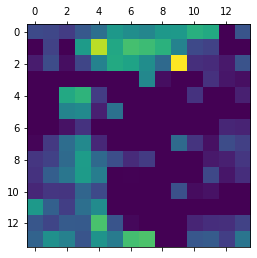

In [42]:
# original grad-cam
cam = np.zeros([14,14,512])
for i in range(512) :
    cam[:,:,i] = last_conv_layer_output_value[:,:,i] * pooled_grads[i]
heatmap = np.mean(cam, axis=-1)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /=np.max(heatmap)
plt.matshow(heatmap)

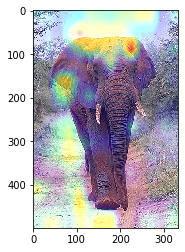

In [43]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./Grad-CAM/{0}_gradcam.jpg'.format(target), superimposed_img)
grad_cam_img = mpimg.imread('./Grad-CAM/{0}_gradcam.jpg'.format(target))
plt.imshow(grad_cam_img)
plt.show()